# COVID-19
#### Finding the countries with similar spread 

***

This notebooks aims find the nearest neighbours by their spread evolution. This is usefull because there is a high chance that alike countries will keep evolving in the same way and more relevant data could be fed into a neural network model.

In [1]:
import os
os.chdir('..')

In [2]:
import warnings 
import statistics

import numpy   as np 
import pandas  as pd

import seaborn as sns
from matplotlib import pyplot as plt
# sns.set()
from core.data import utils  as dataUtils

from pandas_profiling import ProfileReport
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. Loading data

The dataset can be downloaded from [Kaggle COVID19 Global Forecasting (week 4)](https://www.kaggle.com/c/covid19-global-forecasting-week-4) competition. It contains the spread evolution for each country. Large countries are divided into zones for better granularity.

In [3]:
allData = pd.read_csv('assets/covid_spread.csv', parse_dates=['Date'])

Preprocess the input dataframe. Fill empty states with their country names (easier future handling).

In [4]:
def preprocess_data(df):
    # fill the state field with name of the country (if it is null)
    renameState     = df['Province_State'].fillna(0).values
    renameCountries = df['Country_Region'].values
    renameState[renameState == 0] = renameCountries[renameState == 0]
    df['Province_State'] = renameState

    return df

In [5]:
allData = preprocess_data(allData)
allData.head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,Afghanistan,Afghanistan,2020-01-22,0.0,0.0
1,Afghanistan,Afghanistan,2020-01-23,0.0,0.0
2,Afghanistan,Afghanistan,2020-01-24,0.0,0.0
3,Afghanistan,Afghanistan,2020-01-25,0.0,0.0
4,Afghanistan,Afghanistan,2020-01-26,0.0,0.0


Because general exploratory data analysis is beyond the purpose of thisnotebook, only a Pandas Report will be provided hence. If one desires to dive deeper into the data, I reccomend this Kaggle kernel:
- [COVID19-Explained through Visualizations](https://www.kaggle.com/anshuls235/covid19-explained-through-visualizations)

In [6]:
# profile = ProfileReport(allData, title='COVI-19 Spread Overview', html={'style':{'full_width':True}}, progress_bar=False)
# profile.to_widgets()

## 2. Comparing

The method of comparing countries is by comparing their growth in Confirmed cases and fatalities. We are only interested into countries/regions more advanced than the current country.   

Inorder to get better results, multiple metrics will be considered and tested.

### 2.2 Approach

Two countries are compared in a sliding window manner by fitting the source country over the cadidate and computing the distance between them. 

In [7]:
def compare_sequence(source, candidate, errorFunc):
    minError = np.inf
    minIdx = -1

    # only check the countries that can influence
    if len(candidate) > len(source):
        noWindows = len(candidate) - len(source)
        windowSize = len(source)

        # sliding window over candidate country
        for i in range(0, noWindows):

            # compute loss
            error = errorFunc(source, candidate[i:i + windowSize])

            # save the min error
            if error <= minError:
                minError = error
                minIdx = i

        return minError, minIdx
    
    return None, None

### 2.3 Nearest neighbours

To get the nearest neighbours, we compute the loss individually for each country for bot both confirmed casses and fatalities. The output will be a dataframe containing the measured error for each country and the index where the loss was at its minimum.

In [8]:
 def get_nearest_sequence(df, state, alignThreshConf = 50, alignThreshDead = 10, errorFunc = mean_absolute_error):
    
    resDf = pd.DataFrame(columns=['Province_State', 'deathError', 'confirmedError', 'deathIdx', 'confirmedIdx'])
    confDf = df[df['ConfirmedCases'] > alignThreshConf]
    deadDf = df[df['Fatalities'] > alignThreshDead]
    
    # get source region data
    regionDfConf = confDf[confDf['Province_State'] == state].sort_values(by='Date', ascending=True)
    regionDfDead = deadDf[deadDf['Province_State'] == state].sort_values(by='Date', ascending=True)
    
    regionConf = regionDfConf['ConfirmedCases'].values
    regionDead = regionDfDead['Fatalities'].values
    
    # check all possible candidates
    for neighbour in df['Province_State'].unique():

        # skip comparing with the same country
        if neighbour == state:
            continue

        # get country candidate
        confNeighDf = confDf[confDf['Province_State'] == neighbour].sort_values(by='Date', ascending = True)
        deadNeighDf = deadDf[deadDf['Province_State'] == neighbour].sort_values(by='Date',  ascending = True)

        neighConf = confNeighDf['ConfirmedCases'].values
        neighDead = deadNeighDf['Fatalities'].values

        # get error for confirmed and neighbour
        confErr, confIdx = compare_sequence(regionConf, neighConf, errorFunc)
        deadErr, deadIdx = compare_sequence(regionDead, neighDead, errorFunc)
        
        # the candidate will be ignored if it does not have enough data
        if confErr is None or deadErr is None:
            continue

        # append result
        res = {'Province_State':neighbour, 'deathError':deadErr, 'confirmedError':confErr,
                   'deathIdx':deadIdx, 'confirmedIdx':confIdx}

        resDf = resDf.append(res, ignore_index=True)

    return resDf

In [9]:
r = get_nearest_sequence(allData, 'Germany', 40, 10)
r.head() 

,Province_State,deathError,confirmedError,deathIdx,confirmedIdx
0,Heilongjiang,2694.571429,73099.196970,12,27
1,Henan,2686.102041,72569.666667,14,1
2,Hubei,1127.959184,38798.090909,3,0
3,Iran,569.469388,32502.515152,8,3
4,Italy,4617.346939,10131.166667,0,0


## 3. Choosing the right metric

### 3.1 Metrics

#### 3.1.3 Mean absolute error

L1 absolute error.

#### 3.1.1 L1 normalized error

L1 norm normalized relative to the source. This yields the error in percentage. This can be very easy thresholded and can be easy to understand.

def l1_norm_error(source, candidate):
    
    error = (abs(source - candidate))
    source[source == 0] = 1e-30       # add for numerical stability
    error = error/source              # normalize the error
    error = error.mean()
    
    return error

#### 3.1.2 Root mean squared log error

This is the metric used in Kaggle competition for evaluation. 

In [11]:
def rmsle_error(source, candidate):
    candidate += 1e-30
    error  = np.log10((source+1)/(candidate+1))
    error  = error * error
    error  = error.mean()
    error  = np.sqrt(error) 
    
    return error

Besides the afore mentrioned losses **L1** and **mean squared error** will be also considered. 

### 3.2 Comparing metrics

Now lets compare the afore mentined losses. It will be important to considered both countries where the disease is wide spreaded and the countries where the pandemic it's in early stages.

In [12]:
def show_country_nn(data, sourceState, alignThreshConf, alignThreshDead, listErrorDf, errorNames):
    
    SHOW_FIRST = 3 # only show the first top neighbours
        
    # setup plot figures
    fig, axes = plt.subplots(len(listErrorDf), 2, figsize=(15, len(listErrorDf) * 3), gridspec_kw={'hspace': 0.3})
    axes = axes.flatten()

    fig.suptitle(sourceState.title() + ' - similar growth', fontsize=20)
    colors = sns.color_palette()[:SHOW_FIRST + 1]

    # only keep aligned data
    showDataConf = data[data['ConfirmedCases'] > alignThreshConf].copy()
    showDataDead = data[data['Fatalities'] > alignThreshDead].copy()
    showData     = [showDataConf, showDataDead]

    for i, (attr, err) in enumerate(zip(['ConfirmedCases', 'Fatalities'], ['confirmedError', 'deathError'])):
        for j, (error, name) in enumerate(zip(listErrorDf, errorNames)):
            legend    = []
            axIdx     = j * 2 + i
            tempError = error.sort_values(by=err, ascending=True)
            
            # of there are less than SHOW_FIRST, on ly disaply what is available
            show = min(SHOW_FIRST, tempError.shape[0])
            
            for k in range(1, show + 1):

                # plot neighbours
                neighbour   = tempError['Province_State'].iloc[k - 1]
                tempShow    = showData[i][showData[i]['Province_State'] == neighbour][attr]
                xAxisValues = [z for z in range(tempShow.shape[0])]
                
                if len(xAxisValues) > 0:
                    legend.append(neighbour)

                sns.lineplot(x=xAxisValues, y=tempShow, color=colors[k], ax=axes[axIdx], linewidth=4.5)

            # plot source country
            tempShow = showData[i][showData[i]['Province_State'] == sourceState][attr]
            xAxisValues = [z for z in range(tempShow.shape[0])]
            sns.lineplot(x=xAxisValues, y=tempShow, color=colors[0], ax=axes[axIdx], linewidth=4.5)

            # final touches to figure
            axes[axIdx].legend(legend + [sourceState])
            axes[axIdx].set_title(name.title() + ' error')
            axes[axIdx].grid(True)
            axes[axIdx].box = True
    return axes

This will show individual results for a country.

In [13]:
def test_metrics(trainData, sourceCountry, alignThreshConf, alignThreshDead):
    
    results    = []
    errorNames = ['L1 norm', 'MSE', 'RMSLE']
    errors     = [l1_norm_error, mean_squared_error, rmsle_error]
    
    # compute error df for each metric
    for error in errors:
        r = get_nearest_sequence(trainData, sourceCountry, alignThreshConf, alignThreshDead , error)
        results.append(r)
    
    # diplay for both fatalities and confirmed cases 
    show_country_nn(trainData, sourceCountry, alignThreshConf, alignThreshDead, results, errorNames)

#### 3.2.1 Average country

There is not exact metric for determining an average country, but a good choice wold be a country from Eastern Europe, where the pandemic did not spread.

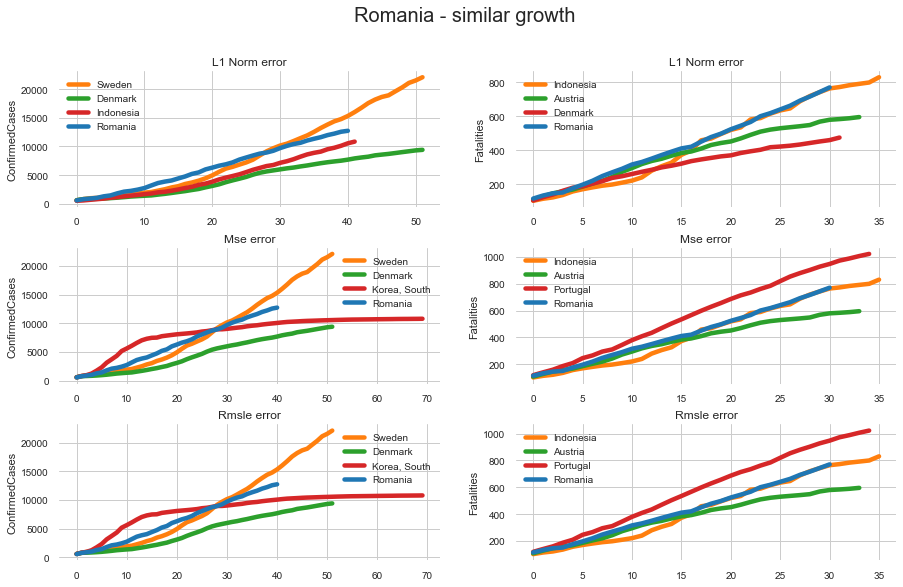

In [14]:
test_metrics(allData, 'Romania', 500, 100)

From the above compared, usually L1 norm and RMSLE yielded the same countries in the same order and they tended to be the ones that are the most accurate.

#### 3.2.2 Evolved country

An evolved country is where the pandemic is wide spreaded and there aren't many countries with more infected thatn them. Such example can be considered Italy or Spain.

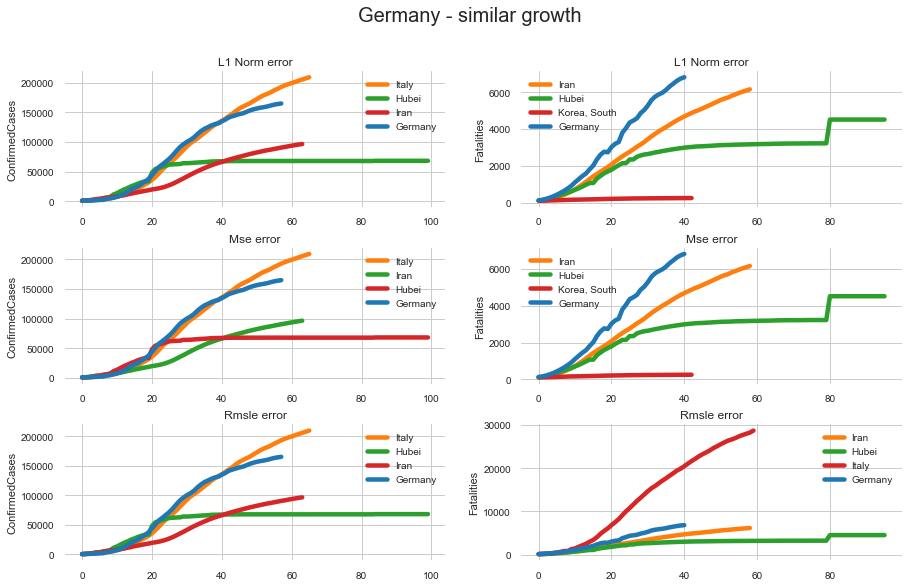

In [15]:
test_metrics(allData, 'Germany', 500, 100)

In this edge cases, the algorithm does not produce relevant results, hence there are countries that resemble the same growth.

## 4. Results

### 4.1 Visualizing results

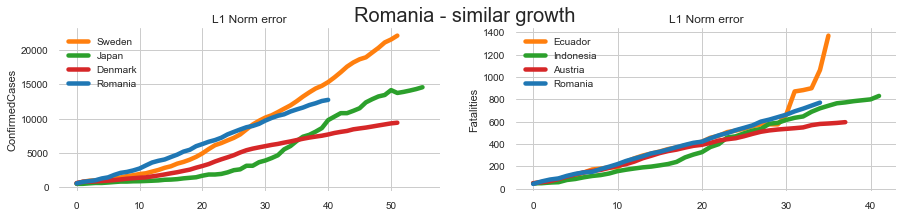

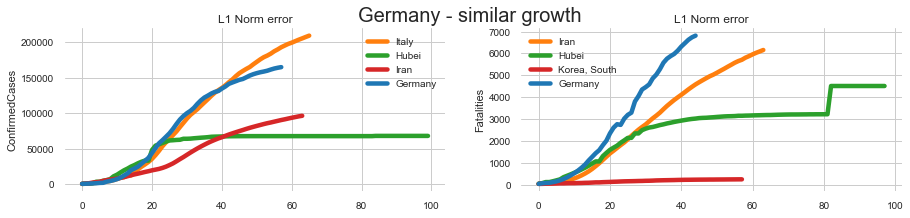

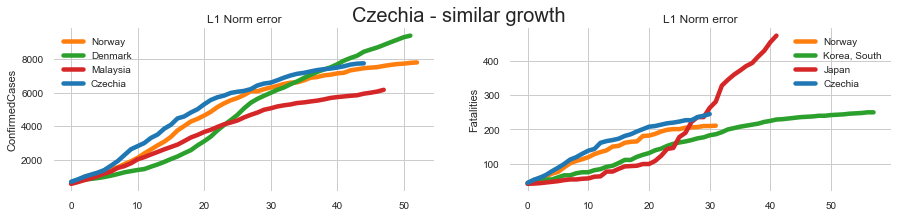

In [16]:
for country in ['Romania', 'Germany', 'Czechia']:
    r = get_nearest_sequence(allData, country, 500, 40, l1_norm_error)
    show_country_nn(allData, country, 500, 40, [r], ['L1 norm'])